# Advanced Audio Processing, part 1: Acoustics and Sound Localization

This is a test Notebook to check if your local installation is working correctly

In [1]:
# All required import
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
from client import array
import time
%matplotlib inline

In [2]:
# antenne=array('server')   # When performing real-time acquisition (acquisition system is required)
antenne=array('play')     # When playing recorded files (can work without acquisition system)

In [3]:
# Load acquisition and array parameters from the antenne variable, AFTER launching acquisition or play
Fs = antenne.fs
BLK = antenne.blocksize
N = antenne.mems_nb
d = antenne.interspace

In [4]:
# Read an audio buffer
m = antenne.read()

In [13]:
def beam_filter(array, freq_vector, theta0=0, mic_nb: int = 0):
    """Compute the filter frequency response of a DSB beamformer for one microphone

    Args:
        array (array_server obj): array structure controlling the acquisition system.
        freq_vector (np.array): frequency vector. 
        theta0 (int, optional): focusing angular direction (in degrees). Defaults to 0.
        mic_id (int, optional): microphone id. Defaults to 0.

    Returns:
        np.array: the filter frequency response. Shape is (len(freq_vector),).
    """

    N = array.mems_nb
    d = array.interspace
    # Microphone position x
    # z = d*(mic_nb - (N+1/2))
    z = (mic_nb -N -1 )/2 *d
    # Filter's frequency response
    W = np.exp(-1j*2*np.pi* (freq_vector/340) *z*np.cos(theta0 * np.pi/180))
    return W

In [6]:
def display_time_signal(audio_buffer, 
                        indexs_of_buffer,
                        fig_size=(8, 5),
                        xlim=(0.04, 0.06),
                        BLK=BLK,
                        Fs=Fs):
    
    T = np.arange(0, BLK/Fs, 1/Fs)
    plt.figure(figsize=fig_size)
    for i in indexs_of_buffer:
        plt.plot(T, audio_buffer[i,:], label=f'm{i}')
        plt.legend()
        plt.xlim(xlim)
    plt.grid()

    
    
def display_frequency_response( audio_buffer, 
                                indexs_of_buffer,
                                freq=None, 
                                fig_size=(15, 5),
                                noise=False, 
                                Fs=Fs  ): 
    """
    This function plot the signal x, fft, phase of the signal
    - x     : signal
    - freq  : The frequency of the geneFsd signal
    - noise : If the signal is a noise we don't set the xlim
    
    """
    num_figurs = 2 * len(indexs_of_buffer)
    fig, axes = plt.subplots(num_figurs//2, 2, figsize=fig_size)
    xlim=(freq - freq/2, freq + freq/2)
    # make a little extra space between the subplots
    fig.subplots_adjust(hspace=0.5)
    

    x = []
    for i in indexs_of_buffer:
        x.append(i); x.append(i)
        
    #The frequency axis
    f = np.fft.fftfreq(audio_buffer[0].size, d=1/Fs)
    for ax, i, cpt in zip(list(axes.flat), x, range(num_figurs)):
        if cpt%2 != 0:
            ax.plot(f, np.abs(np.fft.fft(audio_buffer[i])), label=f"micro{i}" )
        else:
            ax.plot(f, np.angle(np.fft.fft(audio_buffer[i])), label=f"micro{i}")
        # ax.xlim(xlim)
        ax.grid()
        ax.legend()
    fig.suptitle("Temporel, ampl and phase of the {}Hz signal".format(freq))
    
    plt.show()

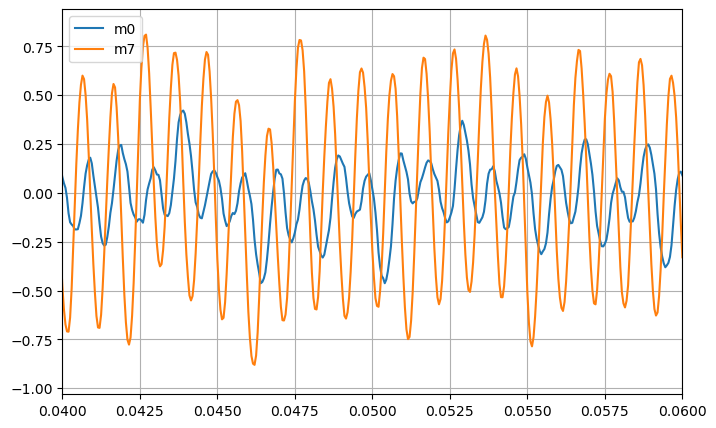

In [7]:
display_time_signal(audio_buffer=m, indexs_of_buffer=[0, 7], fig_size=(8, 5), xlim=(0.04, 0.06), BLK=BLK, Fs=Fs)

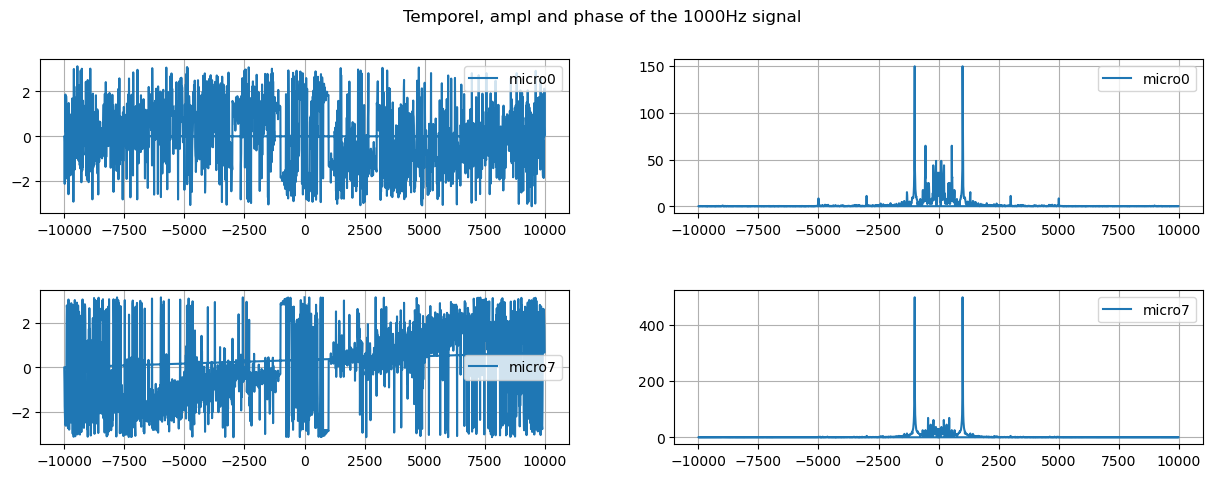

In [8]:
display_frequency_response(     audio_buffer=m, 
                                indexs_of_buffer=[0, 7],
                                freq=1000, 
                                fig_size=(15, 5),
                                noise=False, 
                                Fs=Fs  )

Basically, the beamforming algorithm is the following :  
(a) acquire an audio frame  
(b) compute the corresponding FFT  
(c) analyze the FFT to define which frequency(ies) you would like to localize  
(d) restrict the FFT to the frequencies of interest  
(e) for one given ✓0, for the frequencies selected before, and for each microphone :  
— compute the corresponding filters frequency responses with the beam_filter function  
— apply these filters to the microphone outputs  
(f) compute the beamformer output associated to the angular polarization ✓0  
(g) repeat all these last steps for each ✓0 you want to test  
(h) finally, decide of the angular position of the source by detecting for which ✓0 the beamformer output is maximum  

In [15]:
def filtrage(audio_buffer, array):
    frequencies = np.zeros(audio_buffer.shape[0], dtype=np.complex_)
    filters = np.zeros(audio_buffer.shape[0], dtype=np.complex_)
    for i in range(audio_buffer.shape[0]):
        fft = np.fft.fft(audio_buffer[i, :])
        index = np.argmax(np.abs(fft))
        frequencies[i] = fft[index]
        filters[i] = beam_filter(array, frequencies[i], theta0=0, mic_nb=i)
    return frequencies, filters



In [16]:
frequencies, filters = filtrage(audio_buffer=m, array=antenne)
frequencies, filters


(array([ -40.16398771-144.43475901j,  -86.0786342 +100.36202395j,
          66.008903    -0.79831713j,   27.9559279  -60.92811339j,
          19.62950049-184.48725682j, -124.2759469 -268.37769624j,
        -347.67266107-247.19654487j, -477.35380658-137.99840803j]),
 array([2.01466653-0.40923587j, 0.59461388-0.23872108j,
        0.97036998+0.25416046j, 1.21937784+0.11372084j,
        1.66515193+0.09069519j, 1.74488099-0.49343434j,
        1.26327645-0.82449888j, 1.00588178-0.58840249j]))

In [18]:
conv = frequencies * filters
conv

array([-140.02492683-274.55133057j,  -27.22502034 +80.22543722j,
         64.25595868 +16.00218991j,   41.01763544 -71.1152199j ,
         49.41820669-305.419011j  , -349.27350883-406.96512124j,
       -643.01995887 -25.62185595j, -561.3601047 +142.06608417j])

In [20]:
summ = np.sum(conv)
summ

(-1566.2117187493343-845.3788273622782j)

In [22]:
poww = np.abs(summ)**2
poww

3167684.5097001647